# INTRODUCTION 

Style transfer means taking two images one content image and one style image and use them to create a new image which has the same structure and content as the content image but the colors and texture of the style image. The ground breaking paper [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge was the first to use deep learning for style transfer. 
In this notebook we will try to implement Neural style transfer. For theory I would highly recommend this  [blog post](https://towardsdatascience.com/neural-style-transfer-tutorial-part-1-f5cd3315fa7f) by **Vamshik Shetty**. Pytorch tutorial [Neural Transfer Using PyTorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) is also pretty good as well

# LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms.v2 as T

import random
import os

# CONFIGURATIONS

In [2]:
class CFG:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    mean = torch.tensor([0.485, 0.456, 0.406]) # mean used in pretrained vgg model
    std = torch.tensor([0.229, 0.224, 0.225]) # std used in pretrained vgg mode
    
    image_size = (512, 512)
    
    seed = 1234


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  
    
seed_everything(CFG.seed) # this function does note effect everyting globally

# Loading Content & Style image

In [3]:
def get_transforms(img_size=None):
    """
    img_size: (height, width) of content_image
    """
    transforms = []
    if img_size is not None:
        transforms.append(T.Resize((img_size[0], img_size[1]))) # resize the image
         
    transforms.append(T.ToImage()) # convert the image to pytorch Image datatype
    transforms.append(T.ToDtype(torch.float32, scale=True)) # convert the image to torch float32 and scales the values between 0 and 1
    transforms.append(T.ToPureTensor()) 
    
    return T.Compose(transforms)

def load_image(image_name, transforms):
    """
    Load the image using PIL and transforms the image appropiately for training
    """
    image = Image.open(image_name)
    image = transforms(image).unsqueeze(0).contiguous()
    return image

def dnormalize_image(img):
    """
    accepts img shape of (B, C, H, W) and dnormalize the values according to the pretrained vgg models mean and std
    """
    dnorm_img = img.clone().to(CFG.device) * CFG.std.view(1, 3, 1, 1).to(CFG.device) + CFG.mean.view(1, 3, 1, 1).to(CFG.device)
    return dnorm_img
    

def display_image(img, ax=None, title=""):
    """
    Takes in batch img of form (B, C, H, W) and display the first image
    """
    if ax is None:
        ax = plt.gca() # get current axis
        
    img = img.cpu().numpy()[0]
    img = np.transpose(img, axes=(1, 2, 0))
    
    plt.sca(ax)
    plt.imshow(img)
    plt.title(title)


# content and style path
content_path = "/kaggle/input/small-image-dataset/content_images/small_room.jpg"
style_path = "/kaggle/input/small-image-dataset/style_images/edtaonisl.jpg"  

# loading the content and style image 
content_transforms = get_transforms(CFG.image_size)
style_transforms = get_transforms(CFG.image_size)
content_img =  load_image(content_path, content_transforms)
style_img = load_image(style_path, style_transforms)

assert content_img.shape == style_img.shape, "style and content shape does not match"

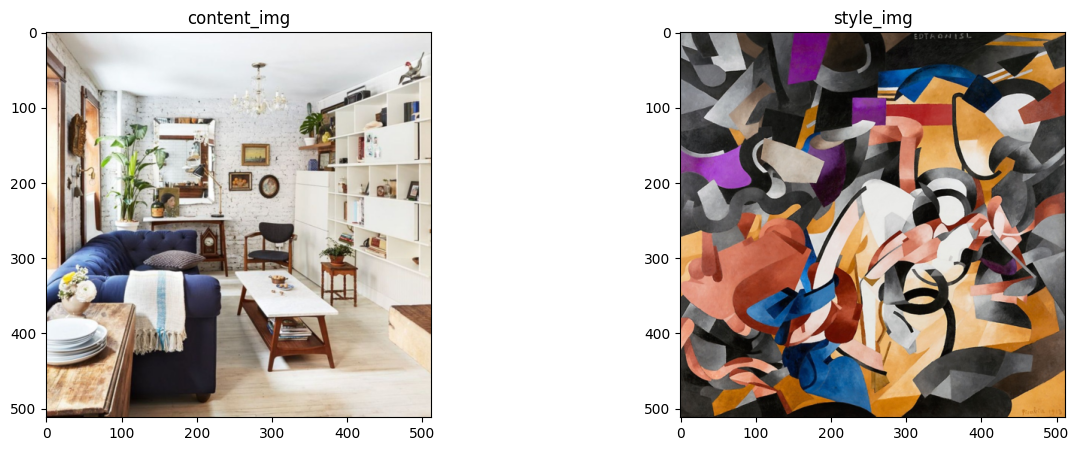

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

display_image(content_img, axes[0], "content_img")
display_image(style_img, axes[1], "style_img")

# MODEl



In [5]:
# First we will create custom vgg19 model which will store all the intermediate feature map like relu1_1, relu2_2
class CustomVGG19(nn.Module):
    def __init__(self):
        super(CustomVGG19, self).__init__()
        
        self.normalizer = T.Normalize(mean=CFG.mean, std=CFG.std)
        
        # block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu1 = nn.ReLU(inplace=False)  # relu1_1
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu2 = nn.ReLU(inplace=False)  # relu1_2
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu3 = nn.ReLU(inplace=False)  # relu2_1
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu4 = nn.ReLU(inplace=False)  # relu2_2
        self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu5 = nn.ReLU(inplace=False)  # relu3_1
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu6 = nn.ReLU(inplace=False)  # relu3_2
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu7 = nn.ReLU(inplace=False)  # relu3_3
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu8 = nn.ReLU(inplace=False)  # relu3_4
        self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 4
        self.conv9 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu9 = nn.ReLU(inplace=False)  # relu4_1
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu10 = nn.ReLU(inplace=False)  # relu4_2
        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu11 = nn.ReLU(inplace=False)  # relu4_3
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu12 = nn.ReLU(inplace=False)  # relu4_4
        self.maxPool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 5
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu13 = nn.ReLU(inplace=False)  # relu5_1
        self.conv14 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu14 = nn.ReLU(inplace=False)  # relu5_2
        self.conv15 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu15 = nn.ReLU(inplace=False)  # relu5_3
        self.conv16 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same", padding_mode="zeros")
        self.relu16 = nn.ReLU(inplace=False)  # relu5_4
        self.maxPool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        output = {}
        
        # normalize values with mean and std of vgg network
        x = self.normalizer(x)
        
        # block 1
        x = self.conv1(x)
        x = self.relu1(x)
        output['relu1_1'] = x
        x = self.conv2(x)
        x = self.relu2(x)
        output['relu1_2'] = x
        x = self.maxPool1(x)
        
        # block 2
        x = self.conv3(x)
        x = self.relu3(x)
        output['relu2_1'] = x
        x = self.conv4(x)
        x = self.relu4(x)
        output['relu2_2'] = x
        x = self.maxPool2(x)
        
        # block 3
        x = self.conv5(x)
        x = self.relu5(x)
        output['relu3_1'] = x
        x = self.conv6(x)
        x = self.relu6(x)
        output['relu3_2'] = x
        x = self.conv7(x)
        x = self.relu7(x)
        output['relu3_3'] = x
        x = self.conv8(x)
        x = self.relu8(x)
        output['relu3_4'] = x
        x = self.maxPool3(x)
        
        # block 4
        x = self.conv9(x)
        x = self.relu9(x)
        output['relu4_1'] = x
        x = self.conv10(x)
        x = self.relu10(x)
        output['relu4_2'] = x
        x = self.conv11(x)
        x = self.relu11(x)
        output['relu4_3'] = x
        x = self.conv12(x)
        x = self.relu12(x)
        output['relu4_4'] = x
        x = self.maxPool4(x)
        
        # block 5
        x = self.conv13(x)
        x = self.relu13(x)
        output['relu5_1'] = x
        x = self.conv14(x)
        x = self.relu14(x)
        output['relu5_2'] = x
        x = self.conv15(x)
        x = self.relu15(x)
        output['relu5_3'] = x
        x = self.conv16(x)
        x = self.relu16(x)
        output['relu5_4'] = x
        x = self.maxPool5(x)
        
        return output


loading the pretrained models weights to out custom model

In [6]:
vgg_pretrained_features = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.eval()
custom_vgg = CustomVGG19()

pretrain_conv_layers = [layer for layer in vgg_pretrained_features if isinstance(layer, nn.Conv2d)]
custom_conv_layers = [layer for layer in custom_vgg.modules() if isinstance(layer, nn.Conv2d)]

assert len(pretrain_conv_layers) == len(custom_conv_layers), "no of weight layers do not match"

for custom_conv_layer, pretrain_conv_layer in zip(custom_conv_layers, pretrain_conv_layers):
    custom_conv_layer.weight.data = pretrain_conv_layer.weight.data.clone()
    custom_conv_layer.bias.data = pretrain_conv_layer.bias.data.clone()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 173MB/s]  


# HOW NEURAL STYLE TRANSFER WORK

<img src="https://github.com/shoabahamed/NST-MODELS/blob/master/ArtisticNeuralStyleTransfer/images/original.jpg?raw=true" style="display:block; margin: auto" title="how style transfer work">
<p style="text-align: center; margin-top:1rem">Fig:<a href="https://devpost.com/software/imageblender#updates"> <u>How Neural Style work</u></a></p>

This picture explain neural style transfer with image optimization method quite well. We have three images content, generated(a white noise/content img/style img) img and style img. We extract their feature maps from different layers using a pretrained vgg network. In the paper they used pretrained vgg19 model. Then you would compare the feature map of content img and generated img to calculate the content loss. Furthermore you would use the feature maps of style img and generated img to calculate the style loss. After that you would sum them up and calculate the toal loss. Then you would calculate the gradients of generated imgs each pixel value and update their pixel values. We would iterate the process until we get a good result.

Usually for content img your would only take one feature map. In the paper they used the output of relu4_2 layer. For style loss you would use the feature map of many layers. In the paper they used the output of 'relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'layer which gives better result then using just one layer. We would explain why this is the case later in the notebook.

***Content Loss:*** Content loss simply the mean squared loss between content feature map and style feature map. 

***Style Loss:*** To understand style loss you have to understand something called gram matrix first. The Gram matrix is a square matrix that represents the inner products of a set of vectors. In our case the vectors are the channels in the feature map. For the feature maps of size (C, H, W) in layer l of the network the we can calculate the gram matrix in these three steps:
1. change the shape of the feature maps from (C, H, W) to (C, H*W)
2. get the inner product of (C, H*W) using matrix multiplication of (C, H*W) and (H*W, C)
3. normalize the gram matrix by dividing by (C*H*W)

We calculate the the gram matrix feature maps at different layers for both style img and generated img and simply get their mean squared loss and sum them up. But what do these gram matrix represent?

You can think of gram matrix here as the correlation between different channels in feature maps.

> Suppose we have a feature maps of size (256, 54, 54) at layer l. Now let’s assume that there is channel ‘A‘ whose activation units may get activated when they come across an image section containing black and brown strips and then there is a channel ‘B’ whose activation units may get activated when they come across something similar to an eyeball. <br> Note: Here units getting activated refer to them having considerably huge value compared to zero after passing through relu. <br> If both of these channels ‘A’ & ‘B’ activate together for the same input, there’s a high possibility that image might contain a face of a tiger ( because it had two channels with high values which activates for eyeball and brown black stripes ). Now if both of these channels are fired up with high activation values that means they would have high correlation compared to correlation between channel ‘A’ & ‘C’ where channel ‘C’ might get activated when it sees a diamond shaped pattern. [Source](https://towardsdatascience.com/neural-style-transfer-tutorial-part-1-f5cd3315fa7f)

In [7]:
def get_gram_matrix(feature_map):
    B, C, H, W = feature_map.size() # B is batch size and in our case 1
    features = feature_map.view(B*C, H*W)
    # need to if inplacd operation is valid or not with name features
    gram_matrix = torch.mm(features, features.t()) # t just transpose a 2d tensor
    return gram_matrix.div(C*W*H) # normalizing the gram matrix according to the paper 

# TRAINING

In [8]:
def run_style_transfer(vgg, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                       content_layer_weights, style_layer_weights, style_weight=100000, content_weight=1,
                       num_steps=300, learning_rate=1):
    
    """Run the style transfer."""
    content_img = content_img.to(CFG.device)
    style_img = style_img.to(CFG.device)
    generated_img = generated_img.to(CFG.device)
    model = vgg.to(CFG.device)
    
    # We want to optimize the input img and not the model parameters so we
    # update all the requires_grad fields accordingly
    generated_img.requires_grad_(True)
    model.requires_grad_(False)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    optimizer = torch.optim.LBFGS([generated_img], lr=learning_rate) # we used LGFGS optimizer because style transfer works well with this
    # content_featue maps and stylized_features
    with torch.no_grad():
        content_feats = model(content_img)
        style_feats = model(style_img)
        style_gram_matrices = {layer_name: get_gram_matrix(feature_map) for layer_name, feature_map in style_feats.items()}

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                generated_img.clamp_(0, 1)

            optimizer.zero_grad()
            
            total_style_loss = 0.0
            total_content_loss = 0.0
            stylized_feats = model(generated_img)
            
            for idx, output_layer_name in enumerate(content_layers_name):
                content_loss = F.mse_loss(stylized_feats[output_layer_name], content_feats[output_layer_name])
                total_content_loss += content_loss * content_layer_weights[idx]
#             print(total_content_loss.item())

            for idx, output_layer_name in enumerate(style_layers_name):
                stylized_gram_matrix = get_gram_matrix(stylized_feats[output_layer_name])
                style_loss = F.mse_loss(stylized_gram_matrix, style_gram_matrices[output_layer_name])
                total_style_loss += style_layer_weights[idx] * style_loss
#             print(total_style_loss.item())

            total_style_loss *= style_weight
            total_content_loss *= content_weight

            loss = total_style_loss + total_content_loss
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} | Content Loss: {:4f} | Total Loss: {:4f}'.format(
                    total_style_loss.item(), total_content_loss.item(), loss.item()))
                print()

            return loss

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        generated_img = generated_img.clip(0, 1)

    return generated_img

In [9]:
content_layers_name = ['relu4_2'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 1*1e7 # weight applied to style loss, increase it for more stylized image
content_weight = 1  # weight applied to content loss
style_layer_weights = [0.2] * len(style_layers_name) # weight assigned to each layer loss for style img
content_layer_weights = [1.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = content_img.clone() 
output = run_style_transfer(custom_vgg, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=1500, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 14.321980 | Content Loss: 8.188655 | Total Loss: 22.510635

run [100]:
Style Loss : 9.119917 | Content Loss: 7.460583 | Total Loss: 16.580500

run [150]:
Style Loss : 7.092863 | Content Loss: 7.089850 | Total Loss: 14.182713

run [200]:
Style Loss : 5.867964 | Content Loss: 6.873378 | Total Loss: 12.741342

run [250]:
Style Loss : 5.118511 | Content Loss: 6.731040 | Total Loss: 11.849550

run [300]:
Style Loss : 4.574330 | Content Loss: 6.610000 | Total Loss: 11.184330

run [350]:
Style Loss : 4.197004 | Content Loss: 6.513556 | Total Loss: 10.710561

run [400]:
Style Loss : 3.876368 | Content Loss: 6.419770 | Total Loss: 10.296138

run [450]:
Style Loss : 3.829568 | Content Loss: 6.395405 | Total Loss: 10.224973

run [500]:
Style Loss : 3.517684 | Content Loss: 6.271837 | Total Loss: 9.789521

run [550]:
Style Loss : 3.419739 | Content Loss: 6.217226 | Total Loss: 9.636965

run [600]:
Style Loss : 3.346948 | Content Loss: 6.179189 | Total Loss: 9.52

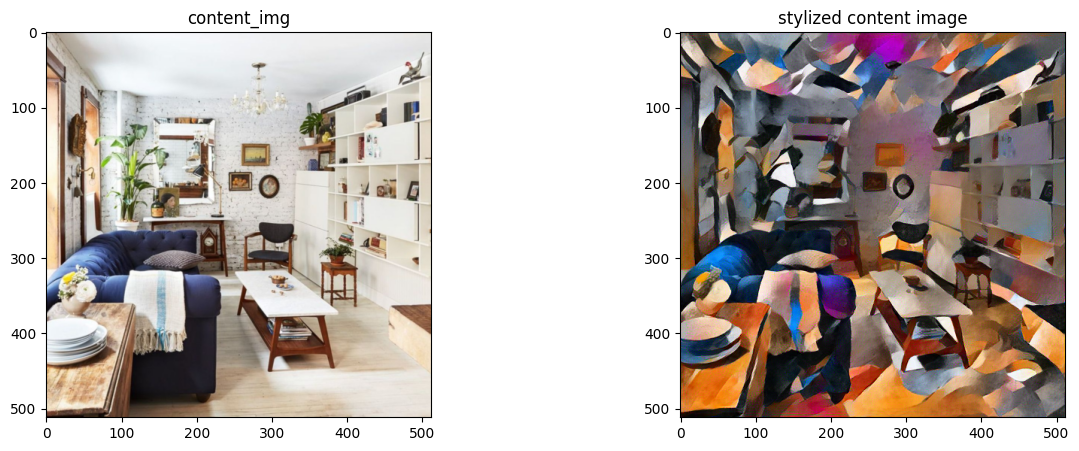

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

display_image(content_img, axes[0], "content_img")
display_image(output, axes[1], "stylized content image")

> ***NOTE1:*** Here we initialized the generated image using content img. According to the paper you can generate style img, content img or even white noise. But the final generated stylized image would be biased towards the final woutThe final generated img would be biased towards the image you initialized with. But from what I experimented with generating a good styled image when initialized with random noise is very hard. 

> ***NOTE2:*** The most important parameters are content_weight and loss weight. In the paper the content_weight/loss_weight was never fixed but they are depended on weights, img size, learning rate and many other things. So you need to tune the parameters for different images for good visually stunning result

# What do you layers output capture

You must have wondered why did we used only one content layer relu4_2 and not the others. At the same time why did we used 5 layers feature maps for style loss. In this section we will try to figure that out

In the next three experiments we set the style weight to zero and generated image with just content images feature map. The feature maps used were of layer relu2_2, relu3_3, relu4_2

In [11]:
content_layers_name = ['relu2_2'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 0
content_weight = 1  
style_layer_weights = [0.2] * len(style_layers_name)
content_layer_weights = [1.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = torch.rand(content_img.size()) 
output = run_style_transfer(custom_vgg, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=300, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 0.000000 | Content Loss: 0.391582 | Total Loss: 0.391582

run [100]:
Style Loss : 0.000000 | Content Loss: 0.185536 | Total Loss: 0.185536

run [150]:
Style Loss : 0.000000 | Content Loss: 0.129865 | Total Loss: 0.129865

run [200]:
Style Loss : 0.000000 | Content Loss: 0.101180 | Total Loss: 0.101180

run [250]:
Style Loss : 0.000000 | Content Loss: 0.082344 | Total Loss: 0.082344

run [300]:
Style Loss : 0.000000 | Content Loss: 0.068291 | Total Loss: 0.068291



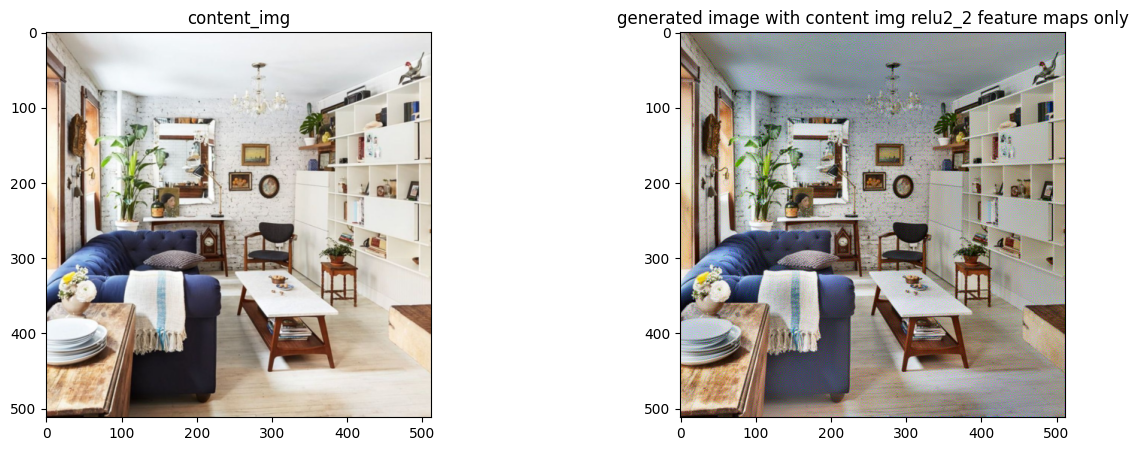

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

display_image(content_img, axes[0], "content_img")
display_image(output, axes[1], "generated image with content img relu2_2 feature maps only")

In [13]:
content_layers_name = ['relu3_3'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 0
content_weight = 1  
style_layer_weights = [0.2] * len(style_layers_name)
content_layer_weights = [1.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = torch.rand(content_img.size()) 
output = run_style_transfer(custom_vgg, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=300, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 0.000000 | Content Loss: 2.177795 | Total Loss: 2.177795

run [100]:
Style Loss : 0.000000 | Content Loss: 1.075465 | Total Loss: 1.075465

run [150]:
Style Loss : 0.000000 | Content Loss: 0.684464 | Total Loss: 0.684464

run [200]:
Style Loss : 0.000000 | Content Loss: 0.490314 | Total Loss: 0.490314

run [250]:
Style Loss : 0.000000 | Content Loss: 0.378439 | Total Loss: 0.378439

run [300]:
Style Loss : 0.000000 | Content Loss: 0.306874 | Total Loss: 0.306874



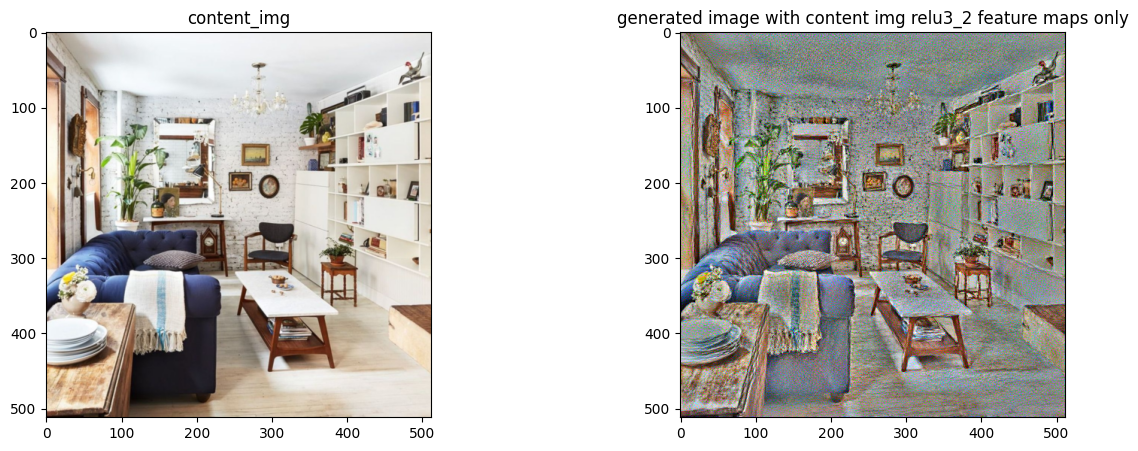

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

display_image(content_img, axes[0], "content_img")
display_image(output, axes[1], "generated image with content img relu3_2 feature maps only")

In [15]:
content_layers_name = ['relu4_2'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 0
content_weight = 1  
style_layer_weights = [0.2] * len(style_layers_name)
content_layer_weights = [1.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = torch.rand(content_img.size()) 
output = run_style_transfer(custom_vgg, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=300, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 0.000000 | Content Loss: 1.613701 | Total Loss: 1.613701

run [100]:
Style Loss : 0.000000 | Content Loss: 0.719271 | Total Loss: 0.719271

run [150]:
Style Loss : 0.000000 | Content Loss: 14.492876 | Total Loss: 14.492876

run [200]:
Style Loss : 0.000000 | Content Loss: 14.492876 | Total Loss: 14.492876

run [250]:
Style Loss : 0.000000 | Content Loss: 14.492876 | Total Loss: 14.492876

run [300]:
Style Loss : 0.000000 | Content Loss: 14.492876 | Total Loss: 14.492876



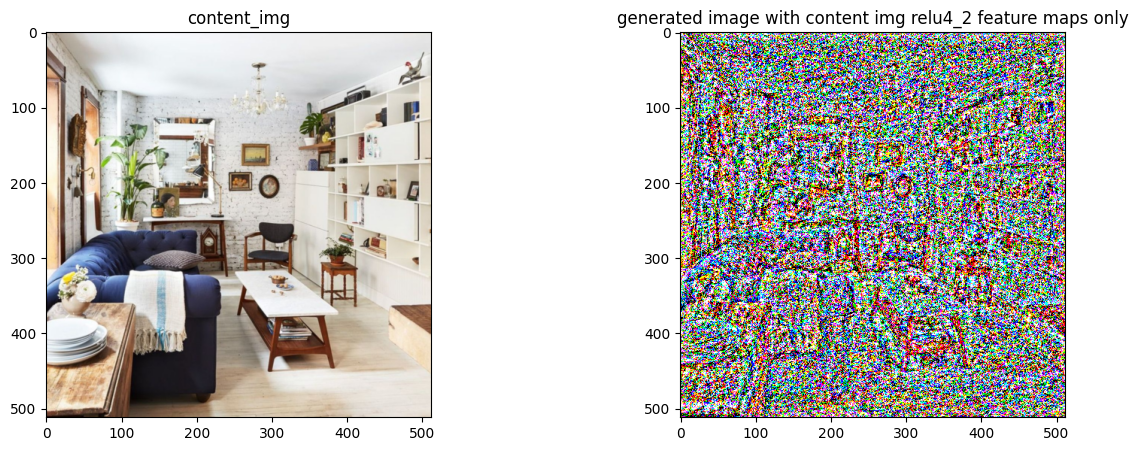

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

display_image(content_img, axes[0], "content_img")
display_image(output, axes[1], "generated image with content img relu4_2 feature maps only")

We can see that as we use deeper layers feature the harder it is for use generate the content image. But regardless of how deep they are content images structure are mostly preserved. But as we go deeper into the network we the pixel values. For style transfer we only want to preserve the content images structures it does not matter if they loss colors or pixel values. If we use shallow layeres feature maps the pixel values would be preserved and it would not be possible to generate a visually good sytlize image. So we used a relatively deeper layer such as relu4_2. You can find more about it in the paper

In the next three experiments we set the content weight to zero and increasingly used deeper style images layers while including the previous layers to. We used relu1_1 and relu1_1, relu2_1, and relu1_1, relu2_1, relu3_1, relu4_1 layers feature maps

In [17]:
content_layers_name = ['relu4_2'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 1e7
content_weight = 0  
style_layer_weights = [1.0, 0.0, 0.0, 0.0, 0.0]
content_layer_weights = [0.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = torch.rand(content_img.size()) 
output = run_style_transfer(custom_vgg, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=300, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 0.983653 | Content Loss: 0.000000 | Total Loss: 0.983653

run [100]:
Style Loss : 0.081189 | Content Loss: 0.000000 | Total Loss: 0.081189

run [150]:
Style Loss : 0.010096 | Content Loss: 0.000000 | Total Loss: 0.010096

run [200]:
Style Loss : 0.003245 | Content Loss: 0.000000 | Total Loss: 0.003245

run [250]:
Style Loss : 0.001112 | Content Loss: 0.000000 | Total Loss: 0.001112

run [300]:
Style Loss : 0.000464 | Content Loss: 0.000000 | Total Loss: 0.000464



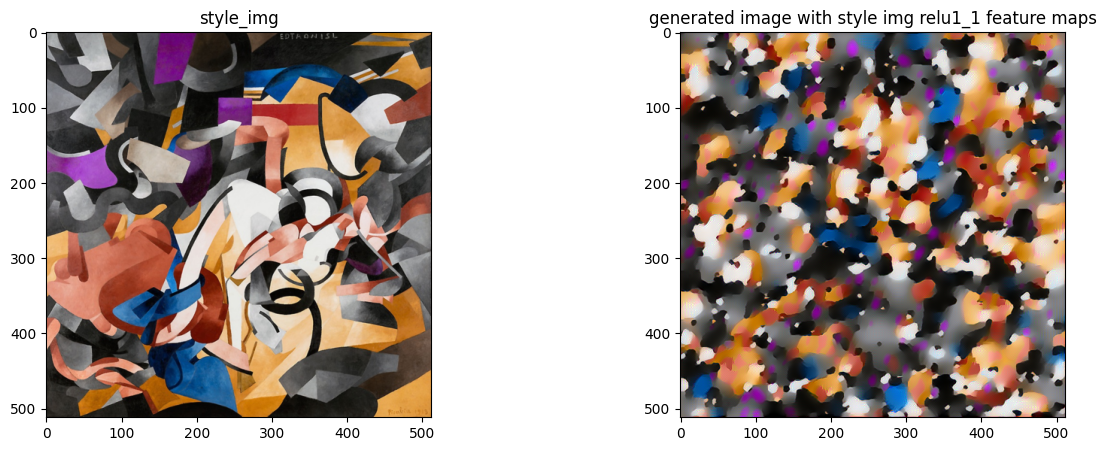

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

display_image(style_img, axes[0], "style_img")
display_image(output, axes[1], "generated image with style img relu1_1 feature maps")

In [19]:
content_layers_name = ['relu4_2'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 1e7
content_weight = 0  
style_layer_weights = [1.0, 1.0, 0.0, 0.0, 0.0]
content_layer_weights = [0.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = torch.rand(content_img.size()) 
output = run_style_transfer(custom_vgg, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=300, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 21.918949 | Content Loss: 0.000000 | Total Loss: 21.918949

run [100]:
Style Loss : 6.665070 | Content Loss: 0.000000 | Total Loss: 6.665070

run [150]:
Style Loss : 3.178616 | Content Loss: 0.000000 | Total Loss: 3.178616

run [200]:
Style Loss : 1.956616 | Content Loss: 0.000000 | Total Loss: 1.956616

run [250]:
Style Loss : 1.348155 | Content Loss: 0.000000 | Total Loss: 1.348155

run [300]:
Style Loss : 0.983183 | Content Loss: 0.000000 | Total Loss: 0.983183



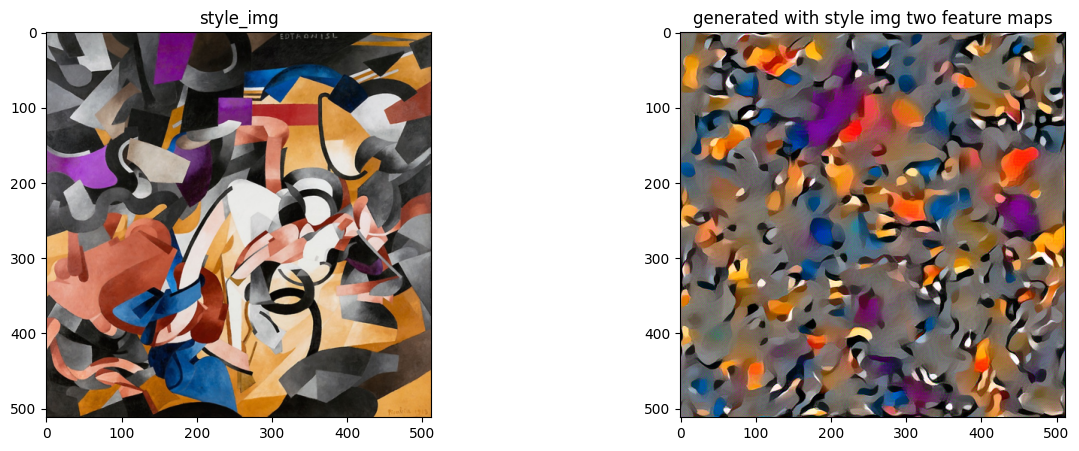

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

display_image(style_img, axes[0], "style_img")
display_image(output, axes[1], "generated with style img two feature maps")

In [21]:
content_layers_name = ['relu4_2'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 1e7
content_weight = 0  
style_layer_weights = [1.0, 1.0, 1.0, 1.0, 0.0]
content_layer_weights = [0.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = torch.rand(content_img.size()) 
output = run_style_transfer(custom_vgg, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=300, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 156.799103 | Content Loss: 0.000000 | Total Loss: 156.799103

run [100]:
Style Loss : 61.046711 | Content Loss: 0.000000 | Total Loss: 61.046711

run [150]:
Style Loss : 36.111835 | Content Loss: 0.000000 | Total Loss: 36.111835

run [200]:
Style Loss : 24.745413 | Content Loss: 0.000000 | Total Loss: 24.745413

run [250]:
Style Loss : 18.628254 | Content Loss: 0.000000 | Total Loss: 18.628254

run [300]:
Style Loss : 14.442945 | Content Loss: 0.000000 | Total Loss: 14.442945



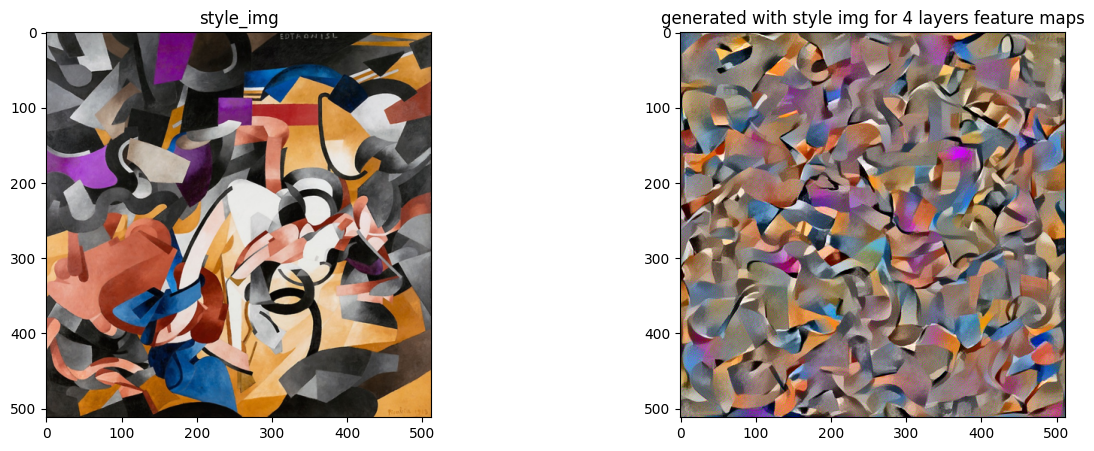

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

display_image(style_img, axes[0], "style_img")
display_image(output, axes[1], "generated with style img for 4 layers feature maps")

We can see that as we use deeper layers feature maps the more patterns of the original style image can be recovered. It is because as you new the shallow layers capture simple lines, colors and textures while as we go deeper it caputes more comlex patterns and structures. It is because as we go deeper into the layers the receptive field of the pixel increases and we see more of the style image. In style transfer we use 5 layers because we want to capture colors, lines from lower levels and also more structures and patterns from deeper layers feature maps

# CONCLUSION

A Neural Algorithm of Artistic Style by Leon A. Gatys had an huge impact on style transfer methods. It can generate stylized image for any style and img size. The results are great too. But it has several problems

1. As image size increases it takes longer and longer to tran
2. Training parameters are unstable and have to tune them for different content image and style


In the next notebook we will implement faster neural style which generate a stylized image in simple forward pass though limited to only one style